<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://colab.research.google.com/drive/199SxVBGDdkuzSzU9pjVP9BfMPzaypLfj#scrollTo=UUSaBpguVsBB




In [117]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])
        print(f'prob: {self.prob}')

    def play(self, arm):
        if self.prob[arm] > random.random():
            return 1.0
        else:
            return 0.0

In [119]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    基準値alephの更新
    RS-greedy選択肢を試行する
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = 0.5

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)      #RS式でゼロ除算を防ぐため, sys.float_info.minでエラーになる可能性がある
        self._N = 0
        self.RS = np.zeros(self._K)

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + self._alpha * reward
        self._n[arm] += 1
        self._N += 1
        self.RS[arm] = (self._n[arm] / self._N) * (self._V[arm] - self.aleph)

    def update_aleph(self):
        #2本腕を想定
        G = random.choice(np.where(self._V == self._V.max())[0])
        if G == 0: j = 1     #このコードは直せ G:(maxIndex), j:(NotMaxIndex)
        else: j = 0
        mu = self._n[j]/self._n[G]
        self.aleph = self._V.max() * (1 - (self._V[j]/self._V[G]) * mu) / 1 - mu      #step数が小さいと upper = lower になる可能性がある #腕の確率が小さいと V(a_G) = V(a_j) = 0 でエラーになる可能性がある(一度も当たらない(かなりレアケース))

    def select_arm(self):
        # maxRS = np.amax(self.RS)        #ここの処理は違うメソッドに(後で書き換えて)
        # print(f'maxRS: {maxRS}')
        # maxIndex = np.where(self.RS == maxRS)[0]
        # return random.choice(maxIndex)
        return np.argmax(self.RS)

In [120]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._agent = RSAgent(K)
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._regret = np.zeros((trial, step))

    def run(self):
        for t in range(self._trial):
            self._env = Environment(K)      #腕の確率を生成
            self._prob = self._env.prob
            self._agent.initialize()
            count = np.array([0] * K)
            print(f'{t}: aleph={self._agent.aleph}')
            for s in range(self._step):
                arm = self._agent.select_arm()
                count[arm] += 1 ### count
                reward = self._env.play(arm)
                self._agent.update(arm, reward)
                self.calc_regret(t, s, arm)
            self._agent.update_aleph()
            # print(f'RS: {self._agent.RS}')
            # print(f'count: {count}')
            # print(f'regret: {self._regret}')
            print()
        self.print_regret()

    def calc_regret(self, t, s, arm):
        self._regret[t][s] += np.amax(self._prob) - self._prob[arm]
        if s != 0: self._regret[t][s] += self._regret[t][s-1]

    def print_regret(self):
        plt.plot(np.arange(self._step), np.mean(self._regret, axis=0), label='RS', linestyle='dashed')
        plt.xlabel('steps')
        plt.ylabel('regret')
        plt.legend()
        plt.show()

prob: [0.90062677 0.11149627]
0: aleph=0.5

prob: [0.88315934 0.97168218]
1: aleph=0.8829999999811701

prob: [0.71951577 0.53213627]
2: aleph=0.9567839195783235

prob: [0.77873987 0.89340912]
3: aleph=0.5435435435280933

prob: [0.71024792 0.90672421]
4: aleph=0.7749999999822494

prob: [0.50465635 0.26920641]
5: aleph=0.90981963925942

prob: [0.87952372 0.3969476 ]
6: aleph=0.5180360721290779

prob: [0.73556948 0.98415269]
7: aleph=0.8909999999810908

prob: [0.27080725 0.42893226]
8: aleph=0.9849699398598697

prob: [0.06233557 0.15642698]
9: aleph=0.4454454454309763

prob: [0.42246167 0.26720623]
10: aleph=0.1391391391277365

prob: [0.39768919 0.7877839 ]
11: aleph=-142900000001.00006

prob: [0.08272831 0.34134435]
12: aleph=-138300000001.0

prob: [0.609006  0.6715141]
13: aleph=-109400000001.00002

prob: [0.30165507 0.23      ]
14: aleph=0.6009999999839892

prob: [0.7181299  0.83105151]
15: aleph=0.21821821820602375

prob: [0.26078133 0.09051123]
16: aleph=0.7349999999826508

prob: [0.

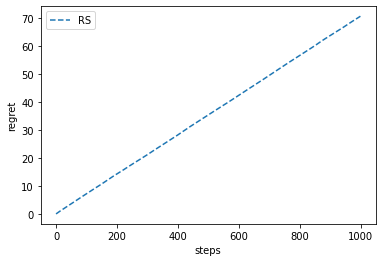

In [121]:
trial = 100
step = 1000     #step数が少ないと n(a_G)=n(a_j) になりaleph更新式がゼロ除算を行ってエラーになる可能性がある
K = 2
sim = Simulator(trial, step, K)
sim.run()